In [4]:
import os
import gc
from pathlib import Path
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
import pickle
from sklearn.preprocessing import normalize

In [5]:
# DATASET_PATH = Path("..", "..", "data", "competition-data")
DATASET_PATH = Path("..","..", "hms-harmful-brain-activity-classification")
training_meta_path = DATASET_PATH / "train.csv"

In [6]:
training_meta_data = pd.read_csv(training_meta_path)
training_meta_data.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [7]:
# for _, grp_df in training_meta_data.groupby("patient_id"):
#     print("="*60)
#     print(grp_df["eeg_id"].value_counts())

In [8]:
# test_meta_data = pd.read_csv(test_meta_path)
# test_meta_data

In [9]:
# test_meta_path = DATASET_PATH / "test.csv"
# test_meta_data = pd.read_csv(test_meta_path)

# test_meta_path["expert_consensus"].value_counts().plot(kind="barh", title="Class Sizes", figsize=(10, 8), color="#52b2bf")
# plt.ylabel("Expert Consensus")
# plt.xlabel("Count")
# plt.show()

In [10]:
# training_meta_data["expert_consensus"].value_counts().plot(kind="pie", title="Class Sizes", figsize=(10, 8), autopct='%1.1f%%', startangle=90, colors=["#7CB9E8", "#72A0C1", "#00308F", "#6CB4EE", "#007FFF", "#6699CC"])
# plt.ylabel("Expert Consensus")
# plt.xlabel("Count")
# plt.show()

In [11]:
unique_eeg_id_list = training_meta_data.groupby("eeg_id").sum().index.values
unique_eeg_id_list

array([    568657,     582999,     642382, ..., 4294455489, 4294858825,
       4294958358], dtype=int64)

In [12]:
%%time
# load all eeg signal into memory (probably change this later to load on the fly to save memory)
eeg_arr = {}

for i, eeg_id in tqdm(enumerate(unique_eeg_id_list[:10])):

    parquet_path = DATASET_PATH / 'train_eegs' / f'{eeg_id}.parquet'
    
    egg_data = pd.read_parquet(parquet_path)
    eeg_arr[eeg_id] = egg_data


10it [00:00, 151.49it/s]

CPU times: total: 0 ns
Wall time: 66 ms


In [13]:
eeg_id = 568657
sampling_rate = 200 # 200 hz

In [14]:
# sub_id_counts = []
# for i, eeg_id_d in tqdm(enumerate(unique_eeg_id_list)):
#     sub_id_counts.append(len(training_meta_data.query(f"eeg_id == {eeg_id_d}").index))


In [15]:
# plt.figure(figsize=(10, 40))
# plt.boxplot(sub_id_counts)
# plt.show()

In [16]:
# sub_id_counts = np.array(sub_id_counts)
# np.unique(sub_id_counts, return_counts=True)

In [17]:
# training_meta_data.query(f"eeg_id == {eeg_id}")

In [18]:
ind = training_meta_data.query(f"eeg_id == {eeg_id}").index[0] 
ind

40927

In [19]:
ind = training_meta_data.query(f"eeg_id == {eeg_id}").index[0] # one sub sample, each eeg_id has multiple sub samples

eeg_label_offset_seconds = training_meta_data.loc[ind, "eeg_label_offset_seconds"]

eeg_data = eeg_arr[eeg_id]

start_ind_sub_data = int(eeg_label_offset_seconds * sampling_rate)
end_ind_sub_data = int(
    (eeg_label_offset_seconds + 50) * sampling_rate
) # 50 second subsample end length

eeg_sub_data = eeg_data[start_ind_sub_data:end_ind_sub_data]

signals = eeg_sub_data.values

print(signals)

eeg_sub_data.head()

[[-7.536000e+01  8.638000e+01  6.547000e+01 ... -1.470000e+00
   7.255000e+01 -3.090090e+03]
 [-1.077400e+02  5.314000e+01  3.259000e+01 ... -2.852000e+01
   4.025000e+01  5.560440e+03]
 [-1.030500e+02  4.633000e+01  1.075000e+01 ... -3.864000e+01
   3.182000e+01 -4.161450e+03]
 ...
 [-5.623000e+01 -9.369000e+01 -3.232000e+01 ... -1.262100e+02
  -5.726000e+01  3.208506e+04]
 [-8.877000e+01 -1.222800e+02 -5.196000e+01 ... -1.493400e+02
  -8.892000e+01 -1.639030e+03]
 [-9.219000e+01 -1.365800e+02 -7.402000e+01 ... -1.557000e+02
  -9.948000e+01  2.770490e+03]]


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-75.360001,86.379997,65.470001,62.580002,170.350006,92.370003,39.68,89.870003,18.260000,-28.440001,-15.190000,16.93,13.81,-42.160000,78.099998,-143.649994,121.239998,-1.470000,72.550003,-3090.090088
1,-107.739998,53.139999,32.590000,21.950001,140.500000,59.070000,4.26,53.310001,-18.490000,-63.270000,-52.110001,-13.23,-16.42,-80.430000,64.449997,-168.500000,88.400002,-28.520000,40.250000,5560.439941
2,-103.050003,46.330002,10.750000,9.150000,137.820007,50.950001,-3.50,45.070000,-20.879999,-66.629997,-69.750000,-9.20,-21.40,-93.089996,5.120000,-176.089996,51.689999,-38.639999,31.820000,-4161.450195
3,-75.099998,77.870003,40.150002,31.790001,166.630005,76.769997,17.99,67.650002,11.140000,-32.950001,-38.509998,14.77,9.79,-66.480003,48.220001,-147.990005,86.629997,-18.639999,62.509998,31769.970703
4,-97.919998,58.209999,27.330000,5.340000,144.080002,47.200001,-10.43,40.250000,-12.350000,-52.500000,-54.919998,-10.07,-8.04,-90.820000,67.269997,-164.710007,80.680000,-36.520000,41.830002,6879.720215


In [20]:
eeg_sub_data.shape

(10000, 20)

The above just proves that the features are not very good at separating the classes

# ICA for Data Cleaning

In [21]:
import numpy as np
import matplotlib.pyplot as plt

import spkit as sp
from spkit.data import load_data

In [22]:
channels = eeg_sub_data.columns[:-1]
channels

Index(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2'],
      dtype='object')

In [23]:

# ignore only EKG channel
X = eeg_sub_data.values[:, :-1]
fs = 200

X.shape

(10000, 19)

In [24]:
X

array([[ -75.36,   86.38,   65.47, ...,  121.24,   -1.47,   72.55],
       [-107.74,   53.14,   32.59, ...,   88.4 ,  -28.52,   40.25],
       [-103.05,   46.33,   10.75, ...,   51.69,  -38.64,   31.82],
       ...,
       [ -56.23,  -93.69,  -32.32, ...,   13.21, -126.21,  -57.26],
       [ -88.77, -122.28,  -51.96, ...,  -11.74, -149.34,  -88.92],
       [ -92.19, -136.58,  -74.02, ...,  -46.65, -155.7 ,  -99.48]],
      dtype=float32)

In [25]:
# the above code was exploratory, now we will create a function to remove artifacts from the eeg data


def remove_artifacts(eeg_subsample, frequency=200):
    """
    remove artifacts on all 20 channels, including EKG. Please remove EKG channel from input data
    if you don't want to remove artifacts from EKG channel.
    """

    X = eeg_subsample

    Xf = sp.filter_X(X, band=[0.70], btype="highpass", fs=frequency, verbose=0)
    # Xf = sp.filter_X(Xf, band=[1], btype="lowpass", fs=frequency, verbose=0)
    # Xf = sp.filter_X(Xf, band=[0.6], btype="notch", fs=frequency, verbose=0)
    XR = sp.eeg.ICA_filtering(
        Xf.copy(), verbose=1, kur_thr=2, corr_thr=0.8, winsize=512
    )

    return Xf - XR

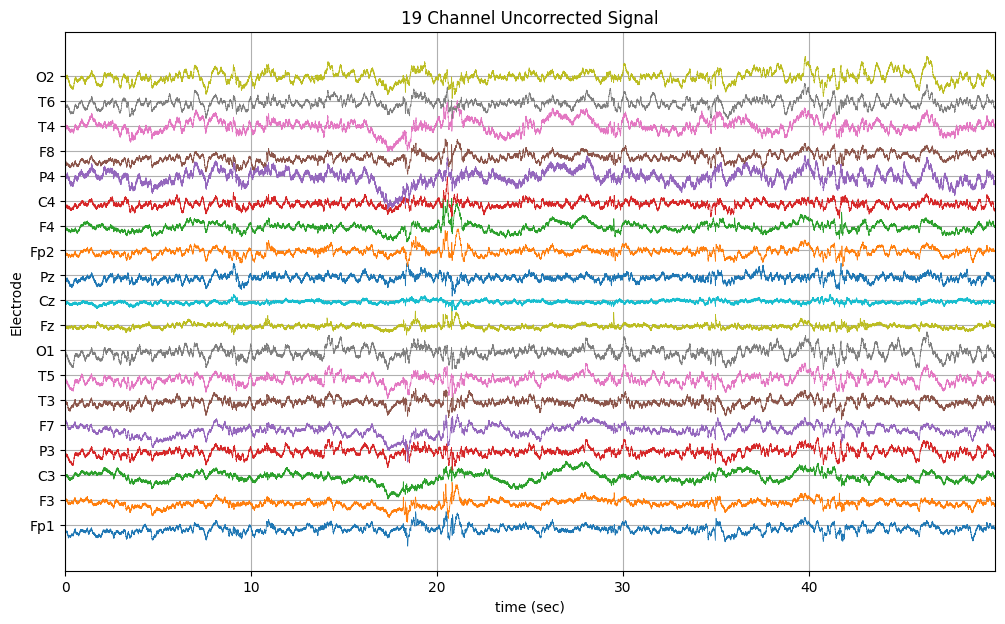

In [26]:
t = np.arange(X.shape[0]) / fs
plt.figure(figsize=(12, 7))
plt.plot(t, X + np.arange(-10, 9) * 500, linewidth=0.5)
plt.xlim([t[0], t[-1]])
plt.xlabel("time (sec)")
plt.yticks(np.arange(-10, 9) * 500, channels)
plt.grid()
plt.ylabel("Electrode")
plt.title("19 Channel Uncorrected Signal")
plt.show()

In [27]:
%%time

removed = remove_artifacts(eeg_sub_data.values[:, :-1])

ICA Artifact Removal : extended-infomax
CPU times: total: 9.11 s################################ |10256\10241|
Wall time: 10.3 s


In [64]:
def plot_signal(signal, thresh=500):
    t = np.arange(signal.shape[0]) / fs

    plt.figure(figsize=(12, 6))
    plt.plot(t, signal + np.arange(-10, 9) * thresh, linewidth=0.5)
    plt.xlim([t[0], t[-1]])
    plt.xlabel("time (sec)")
    plt.yticks(np.arange(-10, 9) * thresh, channels)
    plt.grid()
    plt.ylabel("Electrode")
    plt.title("Corrected Signal")
    plt.ylim([-1000, 1000])  # Adjust the y-axis limits here
    plt.show()

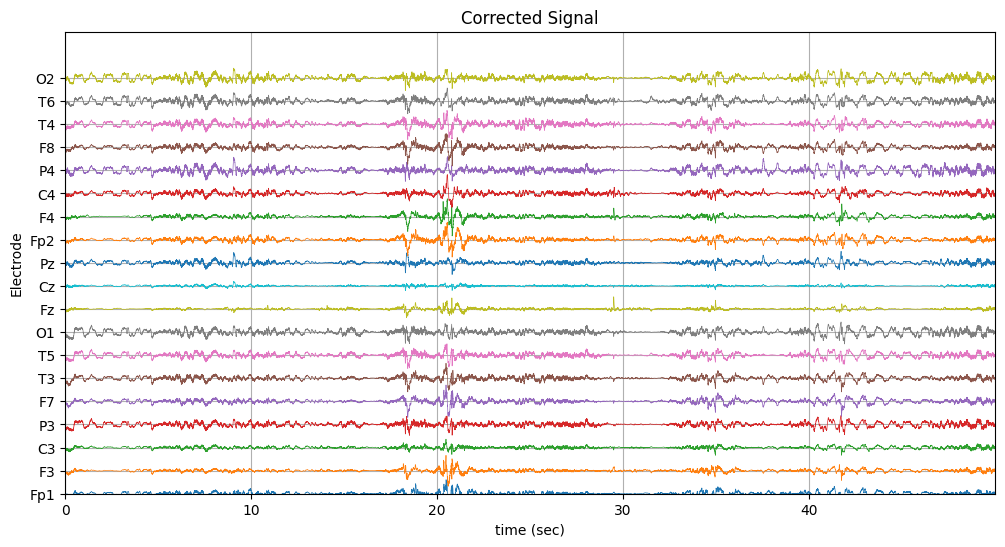

In [59]:
plot_signal(removed)

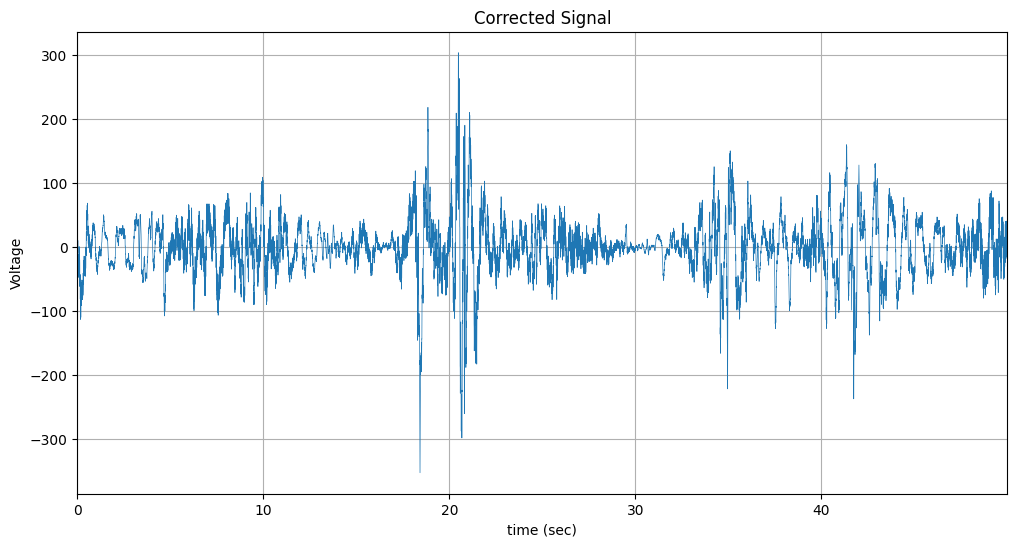

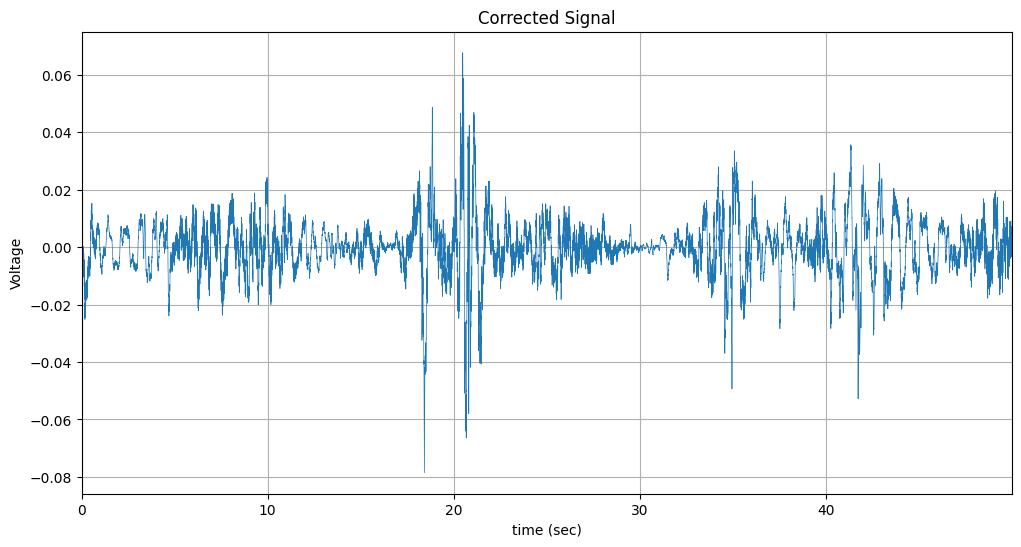

In [165]:
normalized_removed = normalize(removed, norm="l2",axis=0)
# print(removed,normalized_removed)
# plot_signal(normalized_removed)


def plot_single_signal(single_signal):
    t = np.arange(single_signal.shape[0]) / fs

    plt.figure(figsize=(12, 6))
    plt.plot(t, single_signal, linewidth=0.5)
    plt.xlim([t[0], t[-1]])
    plt.xlabel("time (sec)")
    plt.grid()
    plt.ylabel("Voltage")
    plt.title("Corrected Signal")
    plt.show()
    

plot_single_signal(removed[:, 0])
plot_single_signal(normalized_removed[:, 0])


In [61]:
normalized_removed[:, 0].shape

(10000,)

In [72]:
NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]

In [124]:
def montage_from_eeg(eeg):
    montage = np.array([])
    for k in range(4):
        signals = np.zeros(eeg.shape[0])
        COLS = FEATS[k]
        for kk in range(4):
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values
            signals +=x 
        if k == 0:
            montage = signals
        else:
            montage = np.vstack((montage,signals))
    
    return montage

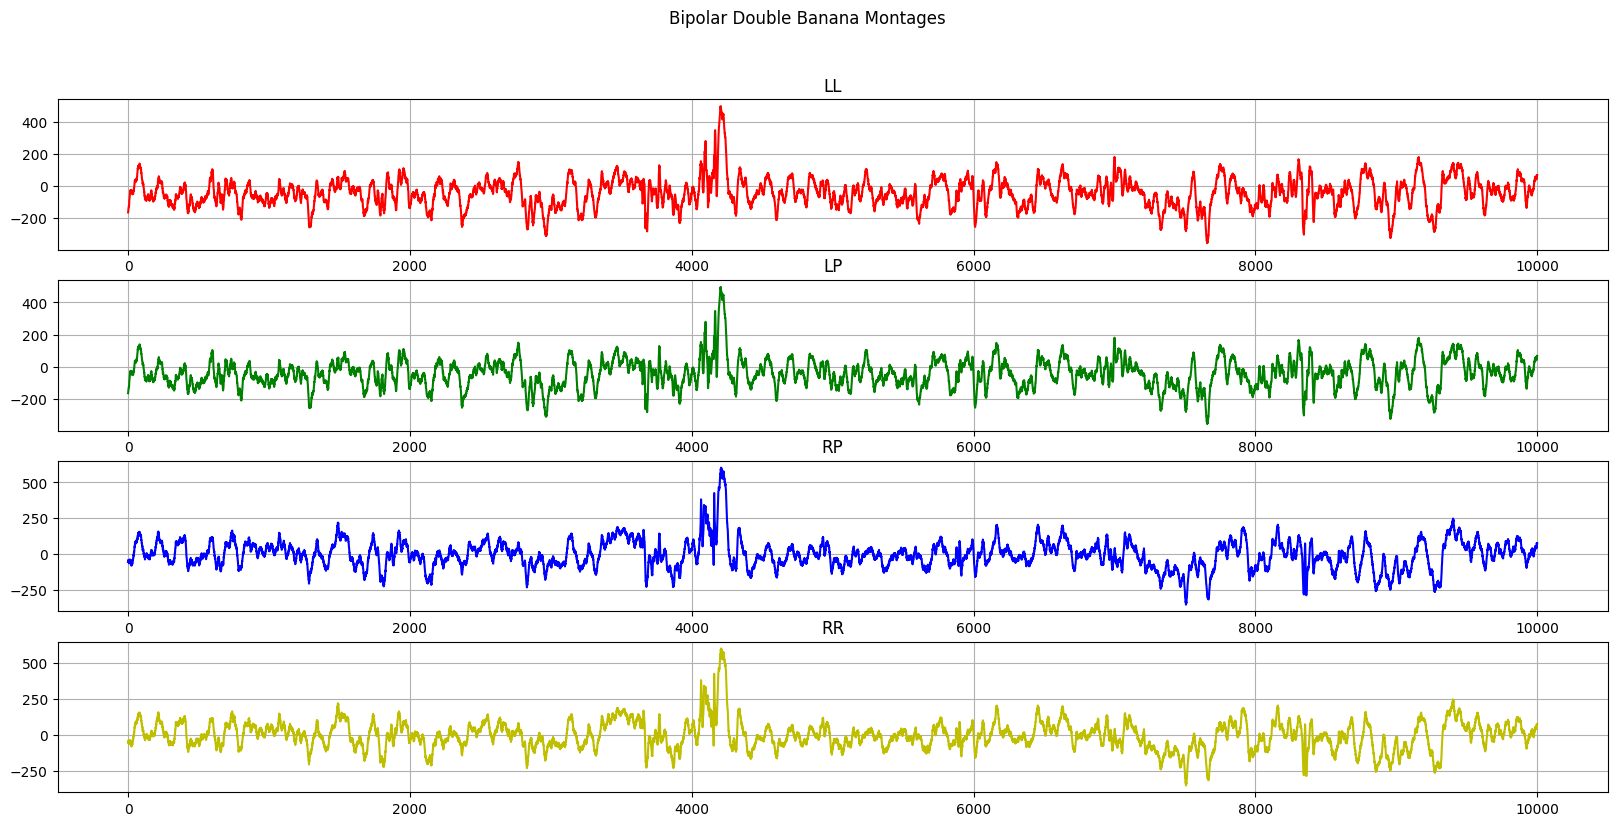

In [163]:
eeg_for_montage=eeg_sub_data.drop(columns=["EKG"])
montages=montage_from_eeg(eeg_for_montage)
plt.figure(figsize=(20, 9))
color = ['r','g','b','y']
for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(montages[i],c=color[i])
    plt.title(NAMES[i])
    plt.grid()
plt.suptitle('Bipolar Double Banana Montages')
plt.show()